# Model comparisons for Figure 6

In [1]:
# imports for the rocky_exo environment

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140
import numpy as np
from spectres import spectres 
from dynesty import NestedSampler
from dynesty import plotting as dyplot
from dynesty import utils as dyutils
from scipy.special import lambertw as W
from scipy.special import erfcinv
import warnings
import pandas as pd

In [1]:
# import for the pandexo environment

import warnings
warnings.filterwarnings('ignore')
import pandexo.engine.justdoit as jdi 
import pandexo.engine.justplotit as jpi
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140
import astropy
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, ScalarFormatter, NullFormatter
from scipy.ndimage import gaussian_filter1d as gauss_conv
import pickle as pk
import numpy as np
import pandas as pd
import scipy.constants as sc
from spectres import spectres 
import copy
import pysynphot as psyn
from os import listdir
import matplotlib

### Figure 6B -- number of eclipses varies, R = 50. 
For 20 eclipses, compare all three JWST simulations (LC10, SE20, TO01) to each of the three models (LC10, SE20, TO01) to derive a statistical measure of model fit probability for each of the three JWST simulations. I know we talked about using just one of the JWST simulations, but they have distinctive features and it would make sense to test all three. If results are good, repeat with 10 eclipses; if good, repeat with 5 eclipses, etc. I can't imagine the fits will be good enough to go that low...



In [7]:
def Z_to_sigma(ln_Z1, ln_Z2):
    """Convert log-evidences of two models to a sigma confidence level
    
    Prameters
    ---------
    ln_Z1: float
        log of Bayesian evidence of model 1
    ln_Z2: float
        log of Bayesian evidence of model 2
        
    Returns
    -------
    
    B: float
        Bayes factor of model 1 to model 2
    sigma: float
        sigma evidence of model 1 over model 2
    """
    np.set_printoptions(precision=50)
    B = np.exp(ln_Z1 - ln_Z2)
    if B < 1.0:
        warnings.warn('Bayes factor is less than 1; sigma-significance is invalid')
        sigma = 0.
    else:
        p = np.real(np.exp(W((-1.0/(B*np.exp(1))),-1)))
        sigma = np.sqrt(2)*erfcinv(p)
    
    return sigma


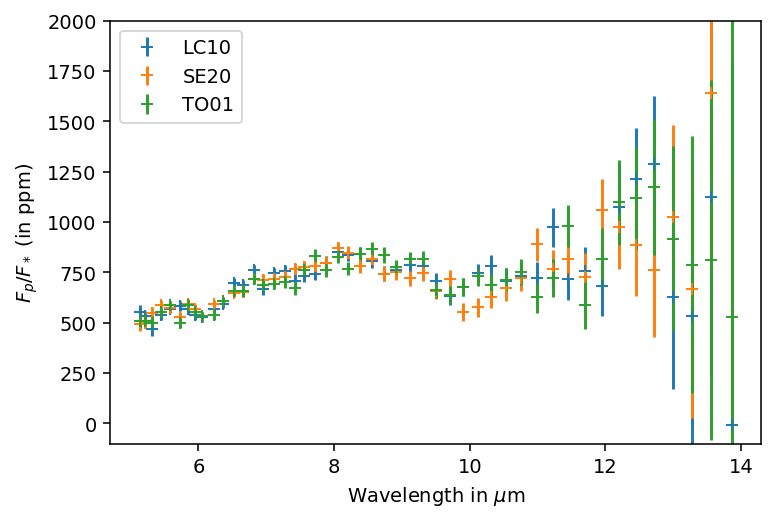

In [3]:
# load and plot data to verify

data = np.loadtxt('simulation_outputs/paper/figure_6/figure_6b/LC10_ntrans_20_jwst.txt', delimiter='\t')
wav_data_lc10, data_lc10, err_lc10 = data[:,0], data[:,1], data[:,2]

data = np.loadtxt('simulation_outputs/paper/figure_6/figure_6b/SE20_ntrans_20_jwst.txt', delimiter='\t')
wav_data_se20, data_se20, err_se20 = data[:,0], data[:,1], data[:,2]

data = np.loadtxt('simulation_outputs/paper/figure_6/figure_6b/TO01_ntrans_20_jwst.txt', delimiter='\t')
wav_data_to01, data_to01, err_to01 = data[:,0], data[:,1], data[:,2]


plt.plot()
plt.errorbar(wav_data_lc10, 10**6*data_lc10, yerr=10**6*err_lc10, ls='', fmt='+', label='LC10')
plt.errorbar(wav_data_se20, 10**6*data_se20, yerr=10**6*err_se20, ls='', fmt='+', label='SE20')
plt.errorbar(wav_data_to01, 10**6*data_to01, yerr=10**6*err_to01, ls='', fmt='+', label='TO01')
plt.ylabel('$F_p/F_*$ (in ppm)')
plt.xlabel('Wavelength in $\mu$m')
plt.ylim((-100,2000))
plt.legend()


### We will try to fit each dataset with a linear mixture model of the three models, and evaluate the Bayesian evidence of each. 

In [4]:
# load the three mineral models

data = np.loadtxt('./simulation_outputs/paper/figure_6/figure_6b/LC10_model.txt')
wav_model_lc10, model_lc10 = data[:,0], data[:,1]

data = np.loadtxt('./simulation_outputs/paper/figure_6/figure_6b/SE20_model.txt')
wav_model_se20, model_se20 = data[:,0], data[:,1]

data = np.loadtxt('./simulation_outputs/paper/figure_6/figure_6b/TO01_model.txt')
wav_model_to01, model_to01 = data[:,0], data[:,1]

# get them all to the same wavelength axes

spec_se20 = spectres(wav_model_lc10, wav_model_se20, model_se20)
spec_to01 = spectres(wav_model_lc10, wav_model_to01, model_to01)

wav_model_se20 = np.copy(wav_model_lc10)
wav_model_to01 = np.copy(wav_model_lc10)

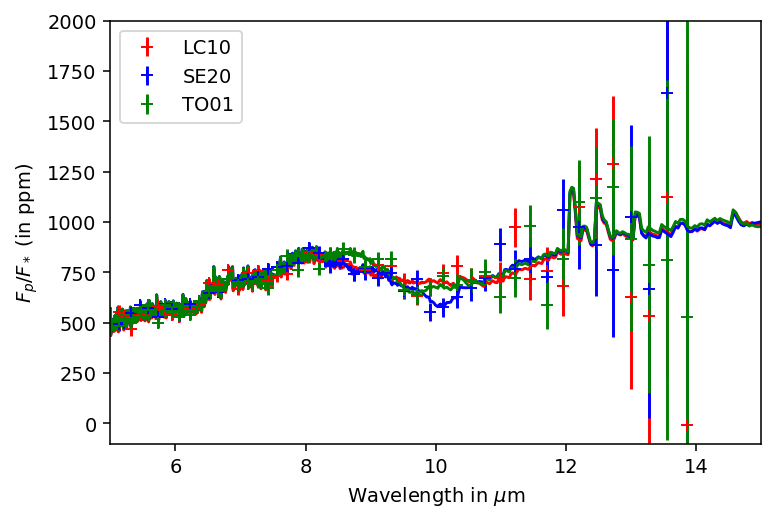

In [5]:
plt.plot()
plt.errorbar(wav_data_lc10, 10**6*data_lc10, yerr=10**6*err_lc10, ls='', fmt='+', label='LC10', color='red')
plt.plot(wav_model_lc10, 10**6*model_lc10, color='red')
plt.errorbar(wav_data_se20, 10**6*data_se20, yerr=10**6*err_se20, ls='', fmt='+', label='SE20', color='blue')
plt.plot(wav_model_se20, 10**6*model_se20, color='blue')
plt.errorbar(wav_data_to01, 10**6*data_to01, yerr=10**6*err_to01, ls='', fmt='+', label='TO01', color='green')
plt.plot(wav_model_to01, 10**6*model_to01, color='green')
plt.ylabel('$F_p/F_*$ (in ppm)')
plt.xlabel('Wavelength in $\mu$m')
plt.ylim((-100,2000))
plt.xlim((5.0,15.0))
plt.legend()

### 1. LC10 data

First with a model with all three rock types

In [8]:
def prior(u):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[-10., 10.)`."""
    
    x = u   # since we are interest in abundances which are between 0 and 1

    return x

norm_log = -0.5*np.sum(np.log(2.0*np.pi*(err_lc10)**2))

def loglik(theta):
    """
    The log-likelihood function.
    
    """
    # unpack parameters

    f_lc10, f_se20 = theta[0], theta[1]

    f_to01 = 1 - f_lc10 - f_se20

    # calculate the total spectrum as the linear sum

    model_total = f_lc10*model_lc10 + f_se20*model_se20 + f_to01*model_to01

    # bin total spectrum to data array

    spec_total = spectres(wav_data_lc10, wav_model_lc10, model_total)
    
    chisq = -0.5*np.sum((spec_total-data_lc10)**2/(err_lc10)**2)

    return chisq + norm_log



In [10]:
nlive = 512      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 2       # number of parameters
sample = 'unif'  # sampling scheme
tol = 0.1         # the stopping criterion

sampler = NestedSampler(loglik, prior, ndims,
                            bound=bound, sample=sample, nlive=nlive)
sampler.run_nested(dlogz=tol, print_progress=True) # output progress bar

iter: 2025 | +512 | bound: 1 | nc: 1 | ncall: 18848 | eff(%): 13.836 | loglstar:   -inf < 400.431 <    inf | logz: 398.829 +/-  0.036 | dlogz:  0.000 >  0.100                                        

Without LC10

In [13]:
def prior(u):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[-10., 10.)`."""
    
    x = u   # since we are interest in abundances which are between 0 and 1

    return x

norm_log = -0.5*np.sum(np.log(2.0*np.pi*(err_lc10)**2))

def loglik(theta):
    """
    The log-likelihood function.
    
    """
    # unpack parameters

    f_se20 = theta

    f_to01 = 1 - f_se20

    # calculate the total spectrum as the linear sum

    model_total =  f_se20*model_se20 + f_to01*model_to01

    # bin total spectrum to data array

    spec_total = spectres(wav_data_lc10, wav_model_lc10, model_total)
    
    chisq = -0.5*np.sum((spec_total-data_lc10)**2/(err_lc10)**2)

    return chisq + norm_log



In [14]:
nlive = 512      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 1       # number of parameters
sample = 'unif'  # sampling scheme
tol = 0.1         # the stopping criterion

sampler = NestedSampler(loglik, prior, ndims,
                            bound=bound, sample=sample, nlive=nlive)
sampler.run_nested(dlogz=tol, print_progress=True) # output progress bar

iter: 1526 | +512 | bound: 0 | nc: 1 | ncall: 10603 | eff(%): 20.196 | loglstar:   -inf < 398.645 <    inf | logz: 398.020 +/-    nan | dlogz:  0.000 >  0.100                                        

In [15]:
# Evidence of LC10 model

B, sigma = Z_to_sigma(398.584, 397.884)
sigma

1.8254673479775831

Without SE20

In [16]:
def prior(u):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[-10., 10.)`."""
    
    x = u   # since we are interest in abundances which are between 0 and 1

    return x

norm_log = -0.5*np.sum(np.log(2.0*np.pi*(err_lc10)**2))

def loglik(theta):
    """
    The log-likelihood function.
    
    """
    # unpack parameters

    f_lc10 = theta

    f_to01 = 1 - f_lc10

    # calculate the total spectrum as the linear sum

    model_total =  f_lc10*model_lc10 + f_to01*model_to01

    # bin total spectrum to data array

    spec_total = spectres(wav_data_lc10, wav_model_lc10, model_total)
    
    chisq = -0.5*np.sum((spec_total-data_lc10)**2/(err_lc10)**2)

    return chisq + norm_log



In [17]:
nlive = 512      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 1       # number of parameters
sample = 'unif'  # sampling scheme
tol = 0.1         # the stopping criterion

sampler = NestedSampler(loglik, prior, ndims,
                            bound=bound, sample=sample, nlive=nlive)
sampler.run_nested(dlogz=tol, print_progress=True) # output progress bar

iter: 1490 | +512 | bound: 0 | nc: 1 | ncall: 9794 | eff(%): 21.569 | loglstar:   -inf < 400.430 <    inf | logz: 399.875 +/-    nan | dlogz:  0.000 >  0.100                                         

In [18]:
# Evidence of SE20 model

B, sigma = Z_to_sigma(398.584, 399.875)
sigma

<ipython-input-2-5e70c2a39c60>:24: UserWarning: Bayes factor is less than 1; sigma-significance is invalid
  warnings.warn('Bayes factor is less than 1; sigma-significance is invalid')


1.8264622709666452

Without TO01

In [20]:
def prior(u):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[-10., 10.)`."""
    
    x = u   # since we are interest in abundances which are between 0 and 1

    return x

norm_log = -0.5*np.sum(np.log(2.0*np.pi*(err_lc10)**2))

def loglik(theta):
    """
    The log-likelihood function.
    
    """
    # unpack parameters

    f_lc10 = theta

    f_se20 = 1 - f_lc10

    # calculate the total spectrum as the linear sum

    model_total =  f_lc10*model_lc10 + f_se20*model_se20

    # bin total spectrum to data array

    spec_total = spectres(wav_data_lc10, wav_model_lc10, model_total)
    
    chisq = -0.5*np.sum((spec_total-data_lc10)**2/(err_lc10)**2)

    return chisq + norm_log



In [21]:
nlive = 512      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 1       # number of parameters
sample = 'unif'  # sampling scheme
tol = 0.1         # the stopping criterion

sampler = NestedSampler(loglik, prior, ndims,
                            bound=bound, sample=sample, nlive=nlive)
sampler.run_nested(dlogz=tol, print_progress=True) # output progress bar

iter: 1538 | +512 | bound: 0 | nc: 1 | ncall: 10514 | eff(%): 20.496 | loglstar:   -inf < 398.945 <    inf | logz: 398.297 +/-    nan | dlogz:  0.000 >  0.100                                        

In [22]:
# Evidence of TO01 model

B, sigma = Z_to_sigma(398.584, 398.297)
sigma

1.4725426781537547

### SE20 data

In [24]:
def prior(u):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[-10., 10.)`."""
    
    x = u   # since we are interest in abundances which are between 0 and 1

    return x

norm_log = -0.5*np.sum(np.log(2.0*np.pi*(err_se20)**2))

def loglik(theta):
    """
    The log-likelihood function.
    
    """
    # unpack parameters

    f_lc10, f_se20 = theta[0], theta[1]

    f_to01 = 1 - f_lc10 - f_se20

    # calculate the total spectrum as the linear sum

    model_total = f_lc10*model_lc10 + f_se20*model_se20 + f_to01*model_to01

    # bin total spectrum to data array

    spec_total = spectres(wav_data_se20, wav_model_lc10, model_total)
    
    chisq = -0.5*np.sum((spec_total-data_se20)**2/(err_se20)**2)

    return chisq + norm_log



In [25]:
nlive = 512      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 2       # number of parameters
sample = 'unif'  # sampling scheme
tol = 0.1         # the stopping criterion

sampler = NestedSampler(loglik, prior, ndims,
                            bound=bound, sample=sample, nlive=nlive)
sampler.run_nested(dlogz=tol, print_progress=True) # output progress bar

iter: 2513 | +512 | bound: 2 | nc: 1 | ncall: 19836 | eff(%): 15.654 | loglstar:   -inf < 409.520 <    inf | logz: 406.959 +/-  0.053 | dlogz:  0.000 >  0.100                                        

Without SE20

In [26]:
def prior(u):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[-10., 10.)`."""
    
    x = u   # since we are interest in abundances which are between 0 and 1

    return x

norm_log = -0.5*np.sum(np.log(2.0*np.pi*(err_se20)**2))

def loglik(theta):
    """
    The log-likelihood function.
    
    """
    # unpack parameters

    f_lc10 = theta

    f_to01 = 1 - f_lc10

    # calculate the total spectrum as the linear sum

    model_total =  f_lc10*model_lc10 + f_to01*model_to01

    # bin total spectrum to data array

    spec_total = spectres(wav_data_se20, wav_model_lc10, model_total)
    
    chisq = -0.5*np.sum((spec_total-data_se20)**2/(err_se20)**2)

    return chisq + norm_log



In [27]:
nlive = 512      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 1       # number of parameters
sample = 'unif'  # sampling scheme
tol = 0.1         # the stopping criterion

sampler = NestedSampler(loglik, prior, ndims,
                            bound=bound, sample=sample, nlive=nlive)
sampler.run_nested(dlogz=tol, print_progress=True) # output progress bar

iter: 1481 | +512 | bound: 0 | nc: 1 | ncall: 9597 | eff(%): 21.937 | loglstar:   -inf < 399.265 <    inf | logz: 398.727 +/-    nan | dlogz:  0.000 >  0.100                                         

In [28]:
# Evidence of SE20 model

B, sigma = Z_to_sigma(406.959, 398.727)
sigma

4.455482967413928

Without LC10

In [30]:
def prior(u):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[-10., 10.)`."""
    
    x = u   # since we are interest in abundances which are between 0 and 1

    return x

norm_log = -0.5*np.sum(np.log(2.0*np.pi*(err_se20)**2))

def loglik(theta):
    """
    The log-likelihood function.
    
    """
    # unpack parameters

    f_se20 = theta

    f_to01 = 1 - f_se20

    # calculate the total spectrum as the linear sum

    model_total =  f_se20*model_se20 + f_to01*model_to01

    # bin total spectrum to data array

    spec_total = spectres(wav_data_se20, wav_model_lc10, model_total)
    
    chisq = -0.5*np.sum((spec_total-data_se20)**2/(err_se20)**2)

    return chisq + norm_log

In [31]:
nlive = 512      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 1       # number of parameters
sample = 'unif'  # sampling scheme
tol = 0.1         # the stopping criterion

sampler = NestedSampler(loglik, prior, ndims,
                            bound=bound, sample=sample, nlive=nlive)
sampler.run_nested(dlogz=tol, print_progress=True) # output progress bar

iter: 2119 | +512 | bound: 1 | nc: 1 | ncall: 18866 | eff(%): 14.335 | loglstar:   -inf < 409.491 <    inf | logz: 407.707 +/-  0.043 | dlogz:  0.000 >  0.100                                        

In [32]:
# Evidence of LC10 model

B, sigma = Z_to_sigma(406.959, 407.707)
sigma

<ipython-input-2-5e70c2a39c60>:24: UserWarning: Bayes factor is less than 1; sigma-significance is invalid
  warnings.warn('Bayes factor is less than 1; sigma-significance is invalid')


1.1834474875489727

Without TO01

In [34]:
def prior(u):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[-10., 10.)`."""
    
    x = u   # since we are interest in abundances which are between 0 and 1

    return x

norm_log = -0.5*np.sum(np.log(2.0*np.pi*(err_se20)**2))

def loglik(theta):
    """
    The log-likelihood function.
    
    """
    # unpack parameters

    f_se20 = theta

    f_lc10 = 1 - f_se20

    # calculate the total spectrum as the linear sum

    model_total =  f_se20*model_se20 + f_lc10*model_lc10

    # bin total spectrum to data array

    spec_total = spectres(wav_data_se20, wav_model_lc10, model_total)
    
    chisq = -0.5*np.sum((spec_total-data_se20)**2/(err_se20)**2)

    return chisq + norm_log

In [35]:
nlive = 512      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 1       # number of parameters
sample = 'unif'  # sampling scheme
tol = 0.1         # the stopping criterion

sampler = NestedSampler(loglik, prior, ndims,
                            bound=bound, sample=sample, nlive=nlive)
sampler.run_nested(dlogz=tol, print_progress=True) # output progress bar

iter: 2052 | +512 | bound: 1 | nc: 1 | ncall: 18679 | eff(%): 14.114 | loglstar:   -inf < 409.491 <    inf | logz: 407.839 +/-  0.040 | dlogz:  0.000 >  0.100                                        

In [36]:
# Evidence of TO01 model

B, sigma = Z_to_sigma(406.959, 407.523)
sigma

<ipython-input-2-5e70c2a39c60>:24: UserWarning: Bayes factor is less than 1; sigma-significance is invalid
  warnings.warn('Bayes factor is less than 1; sigma-significance is invalid')


1.0858251756807682

### TO01 data

In [38]:
def prior(u):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[-10., 10.)`."""
    
    x = u   # since we are interest in abundances which are between 0 and 1

    return x

norm_log = -0.5*np.sum(np.log(2.0*np.pi*(err_to01)**2))

def loglik(theta):
    """
    The log-likelihood function.
    
    """
    # unpack parameters

    f_lc10, f_se20 = theta[0], theta[1]

    f_to01 = 1 - f_lc10 - f_se20

    # calculate the total spectrum as the linear sum

    model_total = f_lc10*model_lc10 + f_se20*model_se20 + f_to01*model_to01

    # bin total spectrum to data array

    spec_total = spectres(wav_data_to01, wav_model_lc10, model_total)
    
    chisq = -0.5*np.sum((spec_total-data_to01)**2/(err_to01)**2)

    return chisq + norm_log



In [39]:
nlive = 512      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 2       # number of parameters
sample = 'unif'  # sampling scheme
tol = 0.1         # the stopping criterion

sampler = NestedSampler(loglik, prior, ndims,
                            bound=bound, sample=sample, nlive=nlive)
sampler.run_nested(dlogz=tol, print_progress=True) # output progress bar

iter: 2585 | +512 | bound: 3 | nc: 1 | ncall: 20391 | eff(%): 15.579 | loglstar:   -inf < 398.894 <    inf | logz: 396.194 +/-  0.056 | dlogz:  0.000 >  0.100                                        

Without TO01

In [40]:
def prior(u):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[-10., 10.)`."""
    
    x = u   # since we are interest in abundances which are between 0 and 1

    return x

norm_log = -0.5*np.sum(np.log(2.0*np.pi*(err_to01)**2))

def loglik(theta):
    """
    The log-likelihood function.
    
    """
    # unpack parameters

    f_se20 = theta

    f_lc10 = 1 - f_se20

    # calculate the total spectrum as the linear sum

    model_total =  f_se20*model_se20 + f_lc10*model_lc10

    # bin total spectrum to data array

    spec_total = spectres(wav_data_to01, wav_model_lc10, model_total)
    
    chisq = -0.5*np.sum((spec_total-data_to01)**2/(err_to01)**2)

    return chisq + norm_log

In [41]:
nlive = 512      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 1       # number of parameters
sample = 'unif'  # sampling scheme
tol = 0.1         # the stopping criterion

sampler = NestedSampler(loglik, prior, ndims,
                            bound=bound, sample=sample, nlive=nlive)
sampler.run_nested(dlogz=tol, print_progress=True) # output progress bar

iter: 1741 | +512 | bound: 0 | nc: 1 | ncall: 15908 | eff(%): 14.634 | loglstar:   -inf < 394.082 <    inf | logz: 393.039 +/-  0.026 | dlogz:  0.000 >  0.100                                        

In [42]:
# Evidence of TO01 model

B, sigma = Z_to_sigma(396.194, 393.039)
sigma

3.0065315828793104

Without LC10

In [43]:
def prior(u):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[-10., 10.)`."""
    
    x = u   # since we are interest in abundances which are between 0 and 1

    return x

norm_log = -0.5*np.sum(np.log(2.0*np.pi*(err_to01)**2))

def loglik(theta):
    """
    The log-likelihood function.
    
    """
    # unpack parameters

    f_se20 = theta

    f_to01 = 1 - f_se20

    # calculate the total spectrum as the linear sum

    model_total =  f_se20*model_se20 + f_to01*model_to01

    # bin total spectrum to data array

    spec_total = spectres(wav_data_to01, wav_model_lc10, model_total)
    
    chisq = -0.5*np.sum((spec_total-data_to01)**2/(err_to01)**2)

    return chisq + norm_log

In [44]:
nlive = 512      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 1       # number of parameters
sample = 'unif'  # sampling scheme
tol = 0.1         # the stopping criterion

sampler = NestedSampler(loglik, prior, ndims,
                            bound=bound, sample=sample, nlive=nlive)
sampler.run_nested(dlogz=tol, print_progress=True) # output progress bar

iter: 2132 | +512 | bound: 1 | nc: 1 | ncall: 19943 | eff(%): 13.607 | loglstar:   -inf < 398.286 <    inf | logz: 396.475 +/-  0.043 | dlogz:  0.000 >  0.100                                        

In [45]:
# Evidence of LC10 model

B, sigma = Z_to_sigma(396.194, 396.475)
sigma

<ipython-input-2-5e70c2a39c60>:24: UserWarning: Bayes factor is less than 1; sigma-significance is invalid
  warnings.warn('Bayes factor is less than 1; sigma-significance is invalid')


0.9769023765557276

Without SE20

In [46]:
def prior(u):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[-10., 10.)`."""
    
    x = u   # since we are interest in abundances which are between 0 and 1

    return x

norm_log = -0.5*np.sum(np.log(2.0*np.pi*(err_to01)**2))

def loglik(theta):
    """
    The log-likelihood function.
    
    """
    # unpack parameters

    f_lc10 = theta

    f_to01 = 1 - f_lc10

    # calculate the total spectrum as the linear sum

    model_total =  f_lc10*model_lc10 + f_to01*model_to01

    # bin total spectrum to data array

    spec_total = spectres(wav_data_to01, wav_model_lc10, model_total)
    
    chisq = -0.5*np.sum((spec_total-data_to01)**2/(err_to01)**2)

    return chisq + norm_log

In [47]:
nlive = 512      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 1       # number of parameters
sample = 'unif'  # sampling scheme
tol = 0.1         # the stopping criterion

sampler = NestedSampler(loglik, prior, ndims,
                            bound=bound, sample=sample, nlive=nlive)
sampler.run_nested(dlogz=tol, print_progress=True) # output progress bar

iter: 1552 | +512 | bound: 0 | nc: 1 | ncall: 11794 | eff(%): 18.295 | loglstar:   -inf < 398.900 <    inf | logz: 398.225 +/-    nan | dlogz:  0.000 >  0.100                                        

In [48]:
# Evidence of SE20 model

B, sigma = Z_to_sigma(396.194, 398.225)
sigma

<ipython-input-2-5e70c2a39c60>:24: UserWarning: Bayes factor is less than 1; sigma-significance is invalid
  warnings.warn('Bayes factor is less than 1; sigma-significance is invalid')


nan

In summary:
- for LC10 data, there is no evidence for SE20 but LC10 and TE01 show similar (very weak) evidence.
- for SE20 data, there is strong evidence for SE20 (4.5 $\sigma$), and no evidence for either LC10 or TE01
- for TE01 data, there is moderate evidence for TE01 (3 $\sigma$), and no evidence for either LC10 or SE20.

It will be useful to write a script that can perform this analysis for data generated from varying number of transits, so that we can get detection significance as a function of number of transits.

We shold generate data for more transits

In [2]:
# pandexo environment

import pandexo.engine.justdoit as jdi 
import pandexo.engine.justplotit as jpi
import pickle as pk
import numpy as np

files = ['LC10', 'SE20', 'TO01']
num_transits_list = [30,40,50]

file_prefix = 'simulation_outputs/paper/figure_6/figure_6b/'

R = 50

for file in files:
    for num_transits in num_transits_list:
        
        # load outputs from run

        out = pk.load(open(file_prefix + file + '.p','rb'))
        x,y,y_err = jpi.jwst_1d_spec(out, R=R/2, num_tran=num_transits, model=True, plot=False)
        x,y,y_err = x[0], y[0], y_err[0]
        #x_err = [x[i+1] - x[i] for i in range(x.size-1)]
        #x_err.insert(0,x[1] - x[0])

        # write the wavelength, wav_error, flux and flux_error in a file

        np.savetxt(file_prefix + file + '_ntrans_' + str(num_transits) + '_jwst.txt', np.array([x, y, y_err]).T, delimiter='\t', fmt='%s')

Visually check that the data looks alright

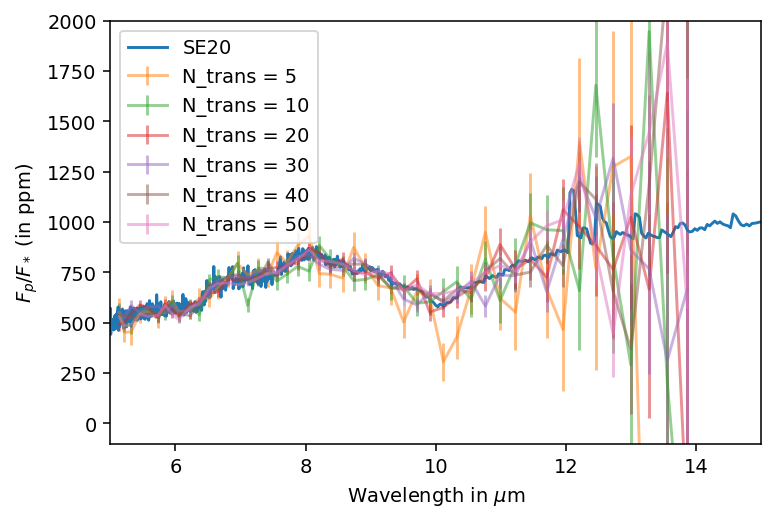

In [14]:
n_transits = [5,10,20, 30, 40, 50]
sample_code = 'SE20'

plt.figure()

data = np.loadtxt('./simulation_outputs/paper/figure_6/figure_6b/' + sample_code + '_model.txt')
wav_model, model = data[:,0], data[:,1]

plt.plot(wav_model, model*10**6, label=sample_code)

for n_transit in n_transits:

    # load data

    file_name = sample_code + '_ntrans_' + str(n_transit) + '_jwst.txt'
    data = np.loadtxt('simulation_outputs/paper/figure_6/figure_6b/' + file_name, delimiter='\t')
    wav_data, data, err = data[:,0], data[:,1], data[:,2]
    plt.errorbar(wav_data, data*10**6, yerr=err*10**6, alpha=0.5, label='N_trans = %d'%n_transit)

plt.ylabel('$F_p/F_*$ (in ppm)')
plt.xlabel('Wavelength in $\mu$m')
plt.ylim((-100,2000))
plt.xlim((5.0,15.0))
plt.legend()

The calculations were performed using `figure_6b.py` script. Load the results here

In [20]:
df_lc10 = pd.read_csv('simulation_outputs/paper/figure_6/figure_6b/LC10_results.csv')


print(df_lc10)

   N_trans      LC10      SE20      TC01
0        5  1.181799  0.000000  0.000000
1       10  0.000000  0.000000  1.453847
2       20  1.909208  0.000000  1.704504
3       30  4.352570  1.505532  0.000000
4       40  6.694887  0.000000  0.000000
5       50  7.813792  0.000000  0.000000


In [16]:
df_se20 = pd.read_csv('simulation_outputs/paper/figure_6/figure_6b/SE20_results.csv')


print(df_se20)

   N_trans      LC10      SE20  TC01
0        5  0.000000  3.242980   0.0
1       10  1.882493  2.690838   0.0
2       20  0.000000  4.452467   0.0
3       30  0.000000  3.595616   0.0
4       40  0.000000  4.054259   0.0
5       50  3.196907  3.448723   0.0


Text(0, 0.5, 'detection significance ($\\sigma$)')

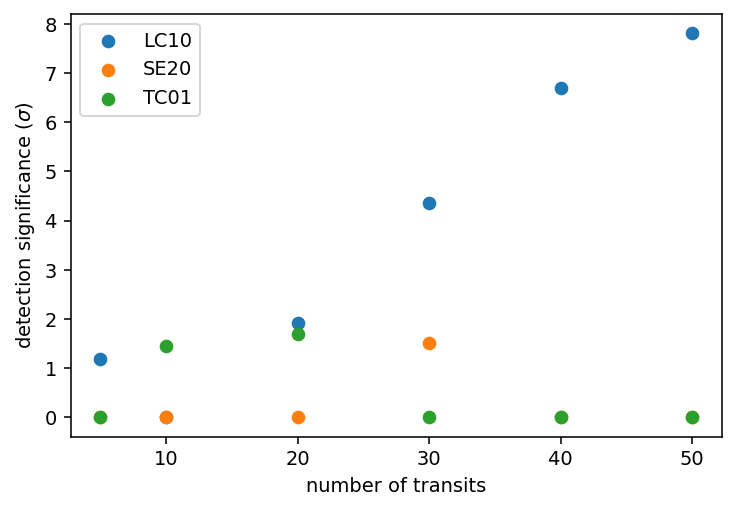

In [4]:
plt.figure()
plt.scatter(df_lc10['N_trans'], df_lc10['LC10'], label='LC10')
plt.scatter(df_lc10['N_trans'], df_lc10['SE20'], label='SE20')
plt.scatter(df_lc10['N_trans'], df_lc10['TC01'], label='TC01')
plt.legend()
plt.xlabel('number of transits')
plt.ylabel('detection significance ($\sigma$)')

Text(0, 0.5, 'detection significance ($\\sigma$)')

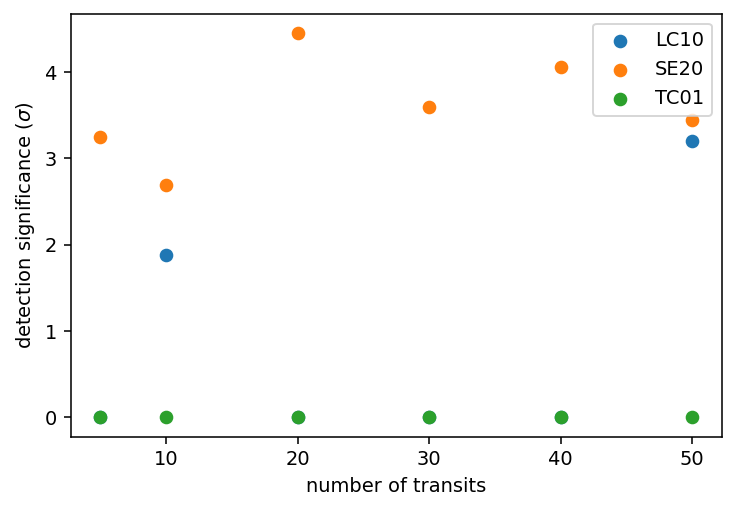

In [17]:
plt.figure()
plt.scatter(df_se20['N_trans'], df_se20['LC10'], label='LC10')
plt.scatter(df_se20['N_trans'], df_se20['SE20'], label='SE20')
plt.scatter(df_se20['N_trans'], df_se20['TC01'], label='TC01')
plt.legend()
plt.xlabel('number of transits')
plt.ylabel('detection significance ($\sigma$)')

Text(0.5, 1.0, 'SE20 JWST data')

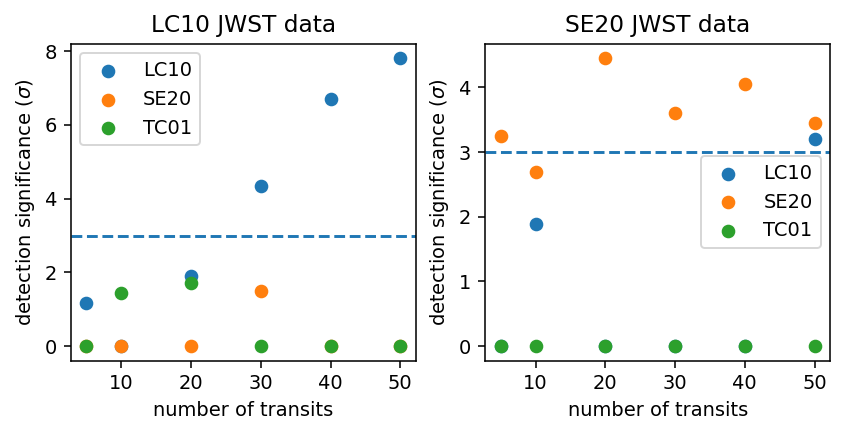

In [28]:
plt.figure(figsize=(7,3))

plt.subplot(1,2,1)
plt.scatter(df_lc10['N_trans'], df_lc10['LC10'], label='LC10')
plt.scatter(df_lc10['N_trans'], df_lc10['SE20'], label='SE20')
plt.scatter(df_lc10['N_trans'], df_lc10['TC01'], label='TC01')
plt.axhline(y=3, ls='--')
plt.legend()
plt.xlabel('number of transits')
plt.ylabel('detection significance ($\sigma$)')
plt.title('LC10 JWST data')

plt.subplot(1,2,2)
plt.scatter(df_se20['N_trans'], df_se20['LC10'], label='LC10')
plt.scatter(df_se20['N_trans'], df_se20['SE20'], label='SE20')
plt.scatter(df_se20['N_trans'], df_se20['TC01'], label='TC01')
plt.axhline(y=3, ls='--')
plt.legend()
plt.xlabel('number of transits')
plt.ylabel('detection significance ($\sigma$)')
plt.title('SE20 JWST data')

SE20's detection does not so a clear trend because the simulated data missed SE20's key feature at 10 $\mu$ m (see below)

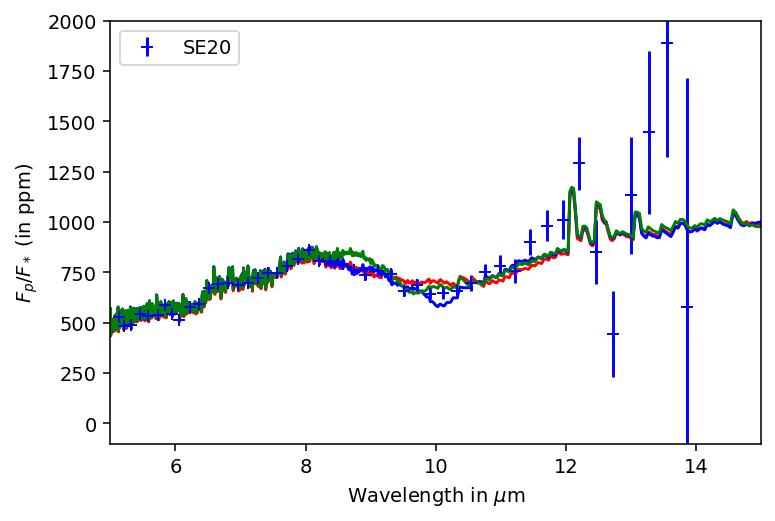

In [10]:
plt.plot()
#plt.errorbar(wav_data_lc10, 10**6*data_lc10, yerr=10**6*err_lc10, ls='', fmt='+', label='LC10', color='red')
plt.plot(wav_model_lc10, 10**6*model_lc10, color='red')
plt.errorbar(wav_data, 10**6*data, yerr=10**6*err, ls='', fmt='+', label='SE20', color='blue')
plt.plot(wav_model_se20, 10**6*model_se20, color='blue')
#plt.errorbar(wav_data_to01, 10**6*data_to01, yerr=10**6*err_to01, ls='', fmt='+', label='TO01', color='green')
plt.plot(wav_model_to01, 10**6*model_to01, color='green')
plt.ylabel('$F_p/F_*$ (in ppm)')
plt.xlabel('Wavelength in $\mu$m')
plt.ylim((-100,2000))
plt.xlim((5.0,15.0))
plt.legend()

### Figure 6C -- R varies, 5 eclipses
Same type of model fit analysis as above, but for R = 30 and R = 50. Possibly R = 100, but only if R = 50 is better than R = 30.

The idea is to find that sweet spot of good (or as good as we can expect) model fit, so ideally we'd have the statistics for that sweet spot as well as something we consider a poor model fit or right at the cusp. That way we kind of bracket the parameter range required to see some of these differences.

### Before retrieval analysis, it will be useful to produce simulated data and visually compare the differences in the 8-11 $\mu$ m region. 

Emily needs the following:

1. Spectra of each sample at R=10, 20, and 30 with 5 eclipses
2. Run one set of simulations with a point for sure at 10 um to check for the SE20 feature and another set of simulations with a point for sure at 9.7 um to check for the TO01 feature

These simulations exist in the figure_6c folder. Load them and plot the 8-11 $\mu$ m region

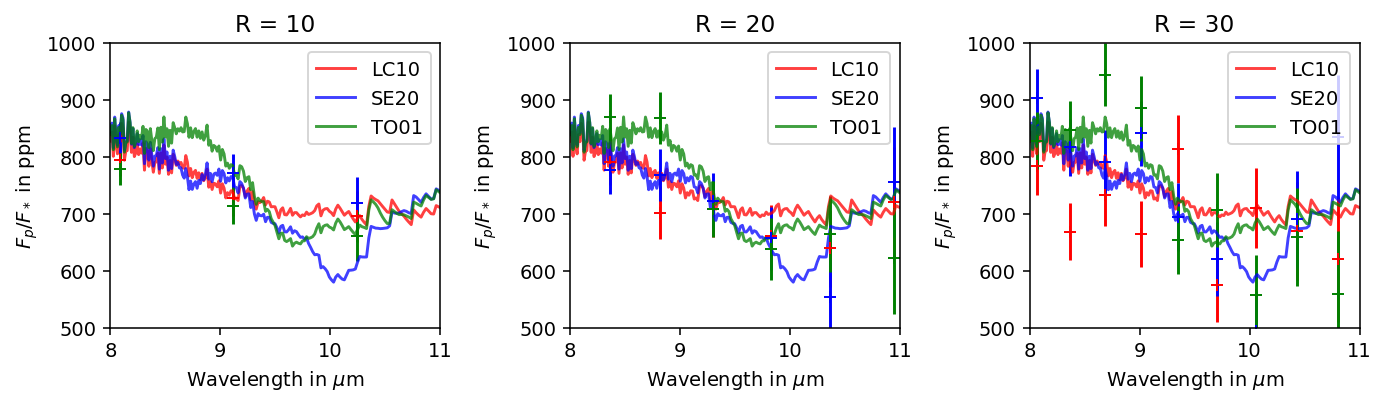

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3))

file_prefix = 'simulation_outputs/paper/figure_6/figure_6c/'

file_list = ['LC10', 'SE20', 'TO01']
R_list = ['10', '20', '30']

# load models

data  = np.loadtxt(file_prefix + 'LC10_model.txt')
wav_model_lc10, spec_model_lc10 = data[:,0], data[:,1]

data  = np.loadtxt(file_prefix + 'SE20_model.txt')
wav_model_se20, spec_model_se20 = data[:,0], data[:,1]

data  = np.loadtxt(file_prefix + 'TO01_model.txt')
wav_model_to01, spec_model_to01 = data[:,0], data[:,1]

wav_model_list = [wav_model_lc10, wav_model_se20, wav_model_to01]
spec_model_list = [spec_model_lc10, spec_model_se20, spec_model_to01]

color_list = ['red','blue', 'green']

for i in range(3):
    R = R_list[i]
    ax[i].set_title('R = ' + R)
    for j in range(3):
        ax[i].plot(wav_model_list[j], spec_model_list[j]*10**6, alpha=0.75, label=file_list[j], color=color_list[j])
        data = np.loadtxt(file_prefix + file_list[j] + '_R_' + R + '_jwst.txt')
        x, y, y_err = data[:,0], data[:,1], data[:,2]
        ax[i].errorbar(x,10**6*y, yerr=10**6*y_err, ls='', fmt='+', color=color_list[j])

    ax[i].set_xlabel('Wavelength in $\mu$m')
    ax[i].set_ylabel('$F_p/F_*$ in ppm')
    ax[i].set_xlim((8,11))
    ax[i].set_ylim((500,1000))

    ax[i].legend()

plt.tight_layout()

These simulated data do not clearly highlight whether the important features, such as the 10 micron SE20 feature, are distinguishable. It will be more useful to show simulated points that lie on top of these features. As Emily suggested, we can create two sets of wavelength axes:

1. One where there is a data point at 10 um to check for the SE20 feature
2. One where there is a data point at 9.7 um to check for the TO01 feature

A simple way to start would be to calculate the $\Delta_{wav}$ for the pandexo simulated data, and create wavelength axis such that a point lies at our desired wavelength, and then populate points around it using the appropriate $\Delta_{wav}$

In [25]:
# create wavelength axis for R=30 between 8 and 11 microns, such that one point lies at 10 microns

file_prefix = 'simulation_outputs/paper/figure_6/figure_6c/'
R = '30'
 
data = np.loadtxt(file_prefix + 'LC10' + '_R_' + R + '_jwst.txt')
x_lc10, y_lc10, y_err_lc10 = data[:,0], data[:,1], data[:,2]

# find the delta_wav

np.diff(x_lc10)

array([0.17720662, 0.22094711, 0.2021263 , 0.23880458, 0.21938475,
       0.24984098, 0.23171417, 0.25988675, 0.24293734, 0.26903954,
       0.27018274, 0.27444753, 0.30560122, 0.31862198, 0.32699998,
       0.33530131, 0.35053747, 0.35245378, 0.37566859, 0.37410853,
       0.38423338, 0.4107418 , 0.41605971, 0.43344925, 0.4469823 ,
       0.46393133, 0.50458043])

The difference is not uniform. Create a wavelength axis starting at 10, and then going $\lambda/R$ around it

In [9]:
wav_new = np.array([10])
R = 30
while wav_new.max() < 11:
    wav_new = np.append(wav_new, wav_new[-1] + wav_new[-1]/R)

while wav_new.min() > 8:
    wav_new = np.insert(wav_new, 0, wav_new[0] - wav_new[0]/R)


wav_new

array([ 7.88746059,  8.15944199,  8.44080206,  8.7318642 ,  9.03296296,
        9.34444444,  9.66666667, 10.        , 10.33333333, 10.67777778,
       11.0337037 ])

Looks good! We will bin the default resolution (R=200?) simulation from pandexo to this new wavelength axes. However, directly using the pandexo output can be problematic because the simulations are noisy. We are just interested in the size of the error-bars. So do the following:

1. Load the default simulation from pandexo for 5 transits
2. Use spectres to bin the original model to the pandexo simulation's wavelength axis.
3. Use this spectres-binned model and the precision per point as the high resolution data.Bin the high resolution data from step 3 to the R=30 wavelength axis we derived above

In [3]:
# Load the default simulation from pandexo for 5 transits

file_prefix = 'simulation_outputs/paper/figure_6/figure_6c/'
file = 'LC10'
num_transits = 5

out = pk.load(open(file_prefix + file + '.p','rb'))
wav_data_default, data_default, err_data_default = jpi.jwst_1d_spec(out, num_tran=num_transits, model=True, plot=False)
wav_data_default, data_default, err_data_default = wav_data_default[0], data_default[0], err_data_default[0]

# Use spectres to bin the original model to the pandexo simulation's wavelength axis.

data  = np.loadtxt(file_prefix + 'LC10_model.txt')
wav_model, spec_model = data[:,0], data[:,1]

wav_data_mod = wav_data_default
data_mod = spectres(wav_data_mod, wav_model, spec_model)

(500.0, 1000.0)

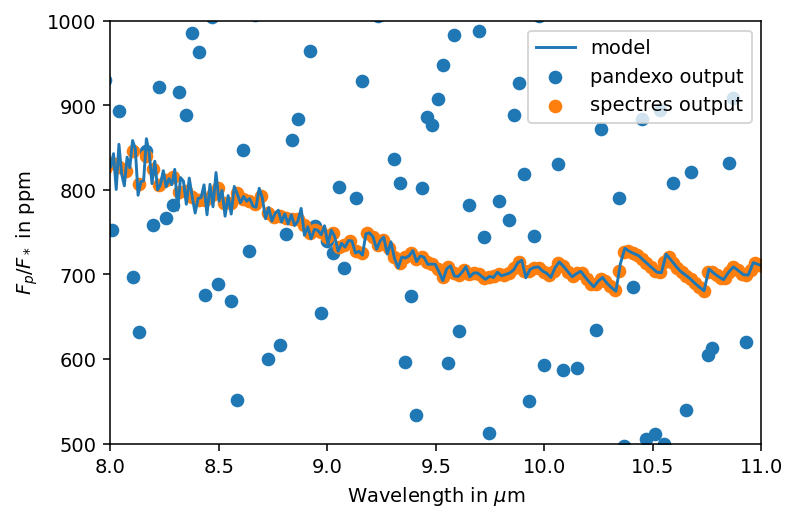

In [5]:
plt.figure()
plt.plot(wav_model, 10**6*spec_model, label='model')
plt.scatter(wav_data_default, 10**6*data_default, label='pandexo output')
plt.scatter(wav_data_mod, 10**6*data_mod, label='spectres output')
plt.legend()
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.xlim((8,11))
plt.ylim((500,1000))


Okay so the degree of randomness has been removed

In [12]:
# Use this spectres-binned model and the precision per point as the high resolution data.
# Bin the high resolution data from step 3 to the R=30 wavelength axis we derived above.

err_data_mod = err_data_default

wav_data_mod_2 = np.array([10])
R = 30
while wav_data_mod_2.max() < 11:
    wav_data_mod_2 = np.append(wav_data_mod_2, wav_data_mod_2[-1] + wav_data_mod_2[-1]/R)

while wav_data_mod_2.min() > 8:
    wav_data_mod_2 = np.insert(wav_data_mod_2, 0, wav_data_mod_2[0] - wav_data_mod_2[0]/R)

ind = (wav_data_mod > 8) & (wav_data_mod < 11)

data_mod_2, err_data_mod_2 = spectres(wav_data_mod_2, wav_data_mod[ind], data_mod[ind], err_data_mod[ind])


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



(500.0, 1000.0)

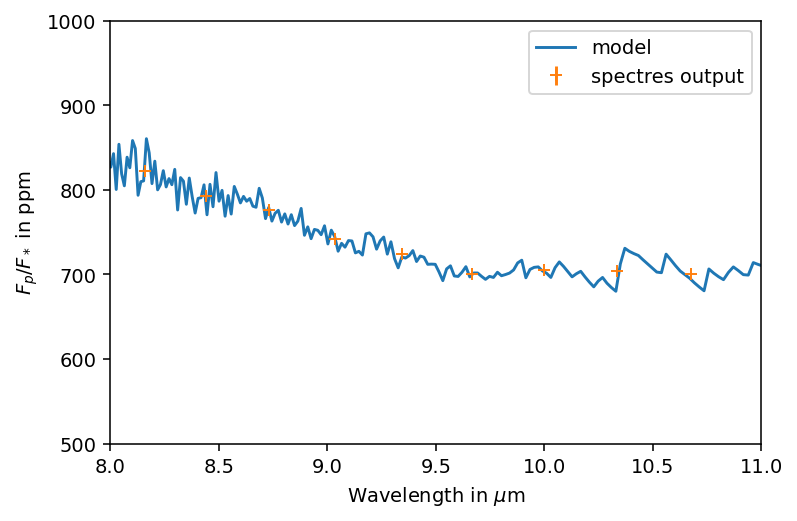

In [18]:
plt.figure()
plt.plot(wav_model, 10**6*spec_model, label='model')
plt.errorbar(wav_data_mod_2, 10**6*data_mod_2, yerr=10**6*err_data_mod_2, label='spectres output', ls='', fmt='+')
plt.legend()
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.xlim((8,11))
plt.ylim((500,1000))

In [23]:
err_data_mod_2

array([           nan, 5.20071786e-05, 5.30868575e-05, 5.62607651e-05,
       5.78560044e-05, 6.15780914e-05, 6.55448857e-05, 7.18397855e-05,
       8.44977013e-05, 1.02892725e-04,            nan])

In [27]:
y_err_lc10[(x_lc10>8) & (x_lc10<11)]

array([5.05256591e-05, 4.99394925e-05, 5.52800715e-05, 5.71939851e-05,
       5.95006049e-05, 6.45969743e-05, 7.00597507e-05, 8.57587930e-05,
       1.09245076e-04])

Spectres derived errorbars and the pandexo errorbars at R=30 match pretty well!

### Okay, now let's produce these R=50, n_trans=5 plots for all three rock types

In [6]:
# Load the default simulation from pandexo for 5 transits

file_prefix = 'simulation_outputs/paper/figure_6/figure_6c/'
file_list = ['LC10','SE20','TO01']
num_transits = 5

wav_data_default_list, data_default_list, err_data_default_list = [],[],[]

for file in file_list:
    out = pk.load(open(file_prefix + file + '.p','rb'))
    wav_data_default, data_default, err_data_default = jpi.jwst_1d_spec(out, num_tran=num_transits, model=True, plot=False)
    wav_data_default, data_default, err_data_default = wav_data_default[0], data_default[0], err_data_default[0]
    wav_data_default_list.append(wav_data_default)
    data_default_list.append(data_default)
    err_data_default_list.append(err_data_default)

# Use spectres to bin the original model to the pandexo simulation's wavelength axis.

wav_data_mod_list, data_mod_list = [],[]
wav_model_list, model_list = [],[]

for i,file in enumerate(file_list):
    data  = np.loadtxt(file_prefix + file + '_model.txt')
    wav_model, model = data[:,0], data[:,1]

    wav_data_mod = wav_data_default_list[i]
    data_mod = spectres(wav_data_mod, wav_model, model)

    wav_model_list.append(wav_model)
    model_list.append(model)
    wav_data_mod_list.append(wav_data_mod)
    data_mod_list.append(data_mod)

# create the new wavelength array between 8 and 11 microns with a point at 10 microns and R=30

wav_data_mod_2 = np.array([10])
R = 30
while wav_data_mod_2.max() < 11:
    wav_data_mod_2 = np.append(wav_data_mod_2, wav_data_mod_2[-1] + wav_data_mod_2[-1]/R)

while wav_data_mod_2.min() > 8:
    wav_data_mod_2 = np.insert(wav_data_mod_2, 0, wav_data_mod_2[0] - wav_data_mod_2[0]/R)


# bin data_mod_list to this new wav_data_mod_2

data_mod_2_list, err_data_mod_2_list = [],[]

for i in range(len(file_list)):

    ind = (wav_data_mod_list[i] > 8) & (wav_data_mod_list[i] < 11)

    data_mod_2, err_data_mod_2 = spectres(wav_data_mod_2, wav_data_mod_list[i][ind], 
                                        data_mod_list[i][ind], err_data_default_list[i][ind])

    data_mod_2_list.append(data_mod_2)
    err_data_mod_2_list.append(err_data_mod_2)



Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



(500.0, 1000.0)

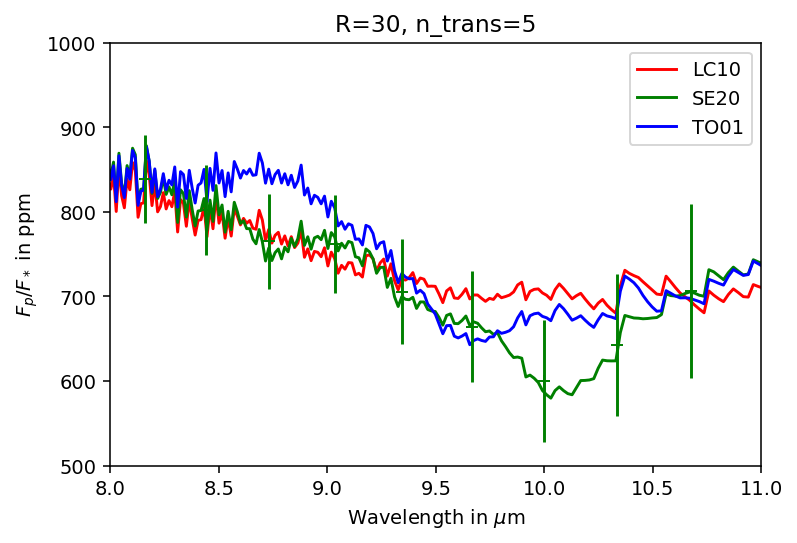

In [11]:
plt.figure()
color_list = ['red', 'green', 'blue']
for i,file in enumerate(file_list):
    plt.plot(wav_model_list[i], 10**6*model_list[i], label=file, color=color_list[i])

plt.errorbar(wav_data_mod_2, 10**6*data_mod_2_list[1], yerr=10**6*err_data_mod_2_list[1], ls='', 
                fmt='+', color=color_list[1])    
plt.legend()
plt.title('R=30, n_trans=5')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.xlim((8,11))
plt.ylim((500,1000))